In [78]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random
%matplotlib inline

In [132]:
class Value:

    def __init__(self, data, _children=[], _op=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self._backward = lambda: None

    def __repr__(self):
        return (f"Value={self.data}")
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data + other.data), [self, other], '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    
    def __radd__(self, other):
        return self + other
    
    def __neg__(self):
        return self * (-1)
    
    def __sub__(self, other):
        return self + (-other)

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value((self.data * other.data), [self, other], '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out
    
    def __rmul__(self, other):
        return self * other
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, [self,], 'ReLU')

        def _backward():
            self.grad += (1.0 if out.data > 0 else 0) * out.grad

        out._backward = _backward

        return out
    
    def __pow__(self, other):

        assert isinstance (other, (float, int))
        out = Value(self.data**other, [self,], f'**{other}')

        def _backward():
            self.grad += other*(self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x)-1)/(math.exp(2*x)+1)
        out = Value(t, (self,), 'tanh')

        def _backward():
            self.grad += (1-t**2)*out.grad
        out._backward = _backward
        
        return out
    
    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()        

In [138]:
class Neuron:

    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        act = sum((xi * wi for xi, wi in zip(x, self.w)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:

    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:

    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]



In [81]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]

ys = [-1, 1, -1, 1]

In [82]:
n = MLP(3, [4,4,1])

In [83]:
for i in range(100):

    #Forward Pass
    preds = [n(x) for x in xs]
    # print(preds)

    #Loss function
    loss = sum((youts - yreal)**2 for yreal, youts in zip(ys, preds))

    #Gradient Zeroing
    for p in n.parameters():
        p.grad = 0.0

    #Backward Pass
    loss.backward()

    #Update weights
    for p in n.parameters():
        p.data += -0.01 * p.grad

    if i%5==0:
        print(i, loss.data)


0 4
5 4
10 4
15 4
20 4
25 4
30 4
35 4
40 4
45 4
50 4
55 4
60 4
65 4
70 4
75 4
80 4
85 4
90 4
95 4


In [84]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    # print(v)
    if v not in nodes:
      nodes.add(v)
      # print(nodes)
      for child in v._prev:
        edges.add((child, v))
        # print(edges)
        build(child)
  build(root)
  # print(nodes, edges)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{data %.4f | grad %.4f}" % (n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

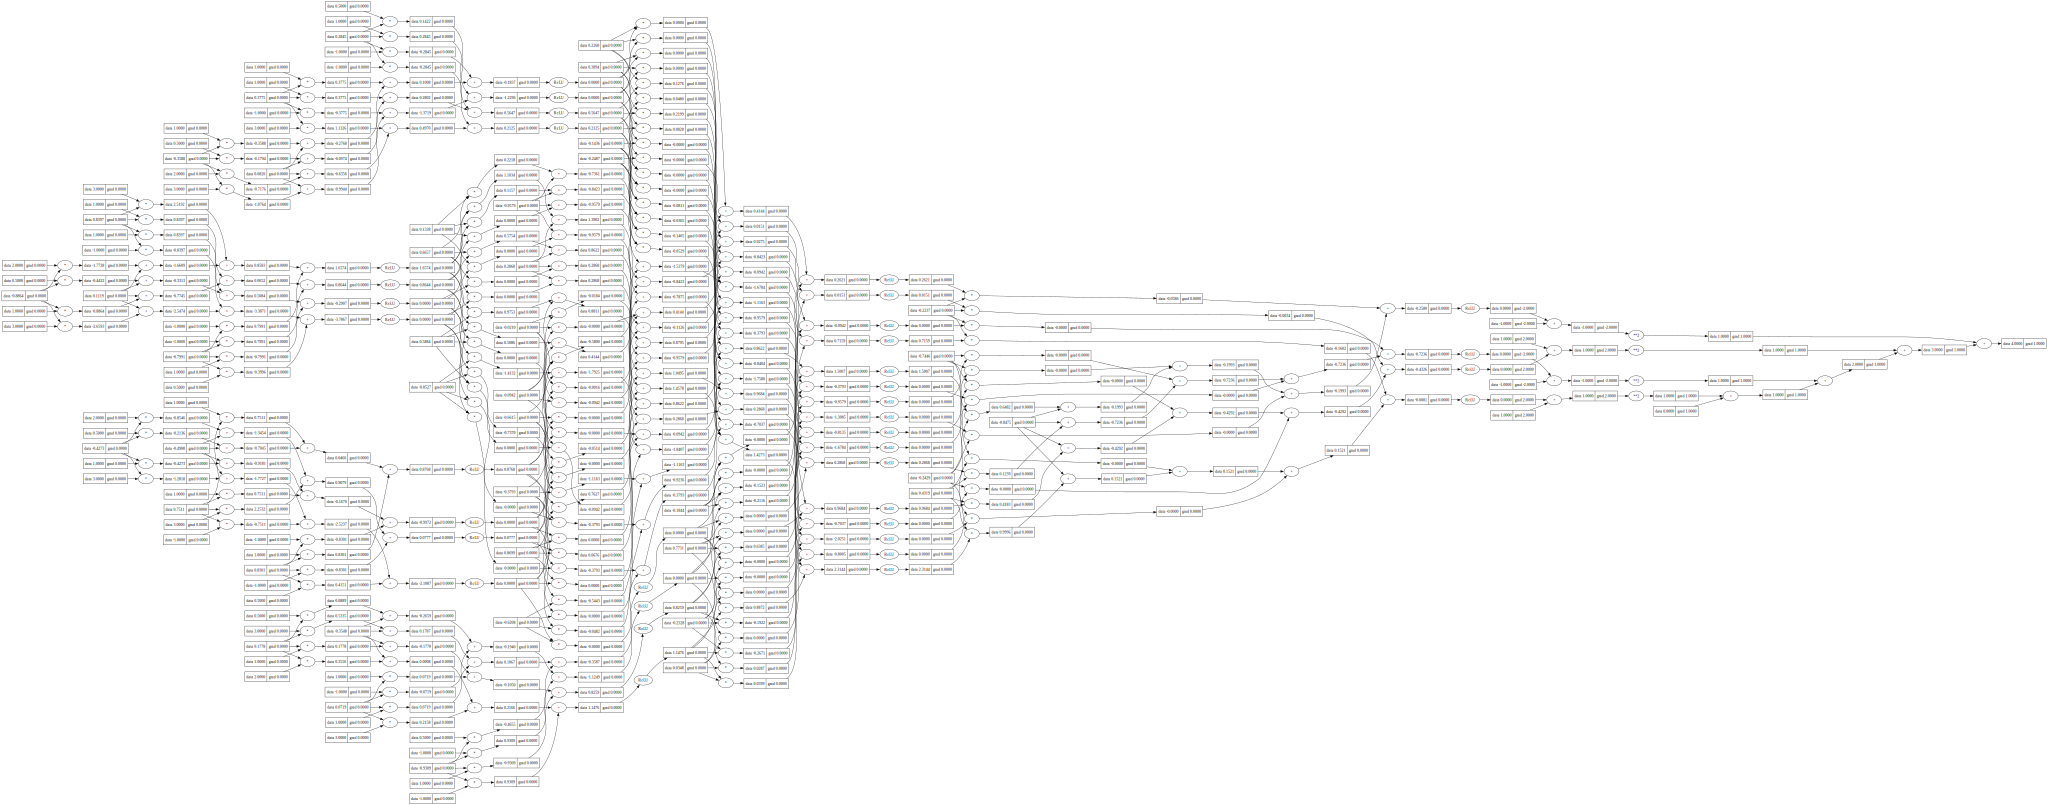

In [85]:
draw_dot(loss)

In [139]:
np.random.seed(1337)
random.seed(1337)

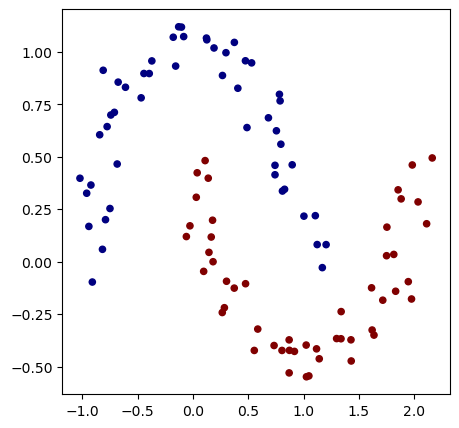

In [140]:
# make up a dataset

from sklearn.datasets import make_moons, make_blobs
X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1 # make y be -1 or 1
# visualize in 2D
plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], c=y, s=20, cmap='jet')

In [141]:
# initialize a model 
model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

number of parameters 337


In [142]:
# loss function
def loss(batch_size=None):
    
    # inline DataLoader :)
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0])[:batch_size]
        Xb, yb = X[ri], y[ri]
    inputs = [list(map(Value, xrow)) for xrow in Xb]
    # print(inputs)
    
    # forward the model to get scores
    scores = list(map(model, inputs))
    # scores = [model(x) for x in inputs]
    # print("scores:", scores)
    
    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    # L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss
    
    # also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy) / len(accuracy)

total_loss, acc = loss()

In [143]:
# optimization
for k in range(100):
    
    # forward
    total_loss, acc = loss()
    
    # backward
    for p in model.parameters():
        p.grad = 0
    total_loss.backward()
    
    # update (sgd)
    learning_rate = 1-0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 1 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")
        # print("Grads: ", model.parameters())

step 0 loss 0.7840043023159259, accuracy 68.0%
step 1 loss 0.5346887893624206, accuracy 73.0%
step 2 loss 0.4048611239882639, accuracy 83.0%
step 3 loss 0.3380828095624803, accuracy 86.0%
step 4 loss 0.29426189790330415, accuracy 88.0%
step 5 loss 0.2713707188453524, accuracy 90.0%
step 6 loss 0.2557758037037018, accuracy 90.0%
step 7 loss 0.24353269446140008, accuracy 91.0%
step 8 loss 0.23311666335881745, accuracy 91.0%
step 9 loss 0.22371429713875024, accuracy 91.0%
step 10 loss 0.2147884062041821, accuracy 91.0%
step 11 loss 0.2060314219010388, accuracy 91.0%
step 12 loss 0.19722264277587243, accuracy 92.0%
step 13 loss 0.18824544635214918, accuracy 93.0%
step 14 loss 0.17902966856680738, accuracy 94.0%
step 15 loss 0.16967500545392217, accuracy 94.0%
step 16 loss 0.16033439848659783, accuracy 94.0%
step 17 loss 0.15200986278726367, accuracy 96.0%
step 18 loss 0.14550876426551512, accuracy 96.0%
step 19 loss 0.15276142639895726, accuracy 95.0%
step 20 loss 0.14406510423987695, accu

(-1.548639298268643, 1.951360701731357)

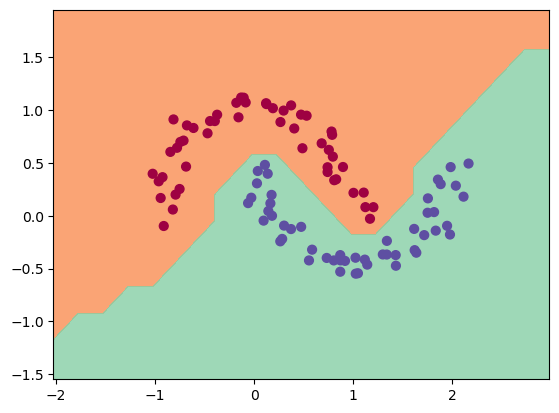

In [144]:
h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())